## 1. Standard Import

In [1]:
from IPython import display

import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional  as F
from scipy.signal import convolve2d

In [4]:
# for getting summary info on models
from torchsummary import summary

In [5]:
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

## 2. Create Gaussian blurs with different widths

In [6]:
# Number of Gaussian blurs images per class
nPerClass = 1500

# Pixel size : heightxwidth = 91x91
imgSize   = 91

x = np.linspace(start=-4, stop=4, num=imgSize)

# Return coordinate matrices from coordinate vectors.
X,Y = np.meshgrid(x,x)

# sigma value : two widths 
# widths have arbitary units
widths = [1.8,2.4]

# initialize tensors containing images and labels
# 1 : grey scale channel
images = torch.zeros(2*nPerClass, 1, imgSize, imgSize)
labels = torch.zeros(2*nPerClass)

for i in range(2*nPerClass):

    # Create the gaussian with random centers
    # Return a sample (or samples) from the "standard normal" distribution.
    # ro = random offset
    ro = 2*np.random.randn(2)    
    
    G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / (2*widths[i%2]**2) )

    # add noise
    G  = G + np.random.randn(imgSize,imgSize)/5

    # add to the tensor
    images[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)
    labels[i] = i%2

# Reshaping into 2D array
labels = labels[:,None]

#### Visualizing some images

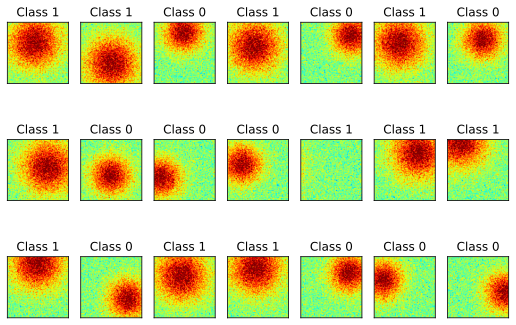

In [7]:
fig,axes = plt.subplots(3,7,figsize=(9,6), dpi=135)

for i,ax in enumerate(axes.flatten()):
    
    whichpic = np.random.randint(2*nPerClass)
    
    G = np.squeeze( images[whichpic,:,:] )
    
    ax.imshow(G, vmin=-1, vmax=1, cmap='jet')
    
    ax.set_title(f'Class {int(labels[whichpic].item())}')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

## 3. Create DataLoader

#### (i) Train-Test split

In [8]:
train_data,test_data, train_labels,test_labels = train_test_split(images, labels, test_size=.15)

#### (ii) Convert into PyTorch Datasets

In [9]:
train_dataset = TensorDataset(train_data,train_labels)
test_dataset  = TensorDataset(test_data,test_labels)

#### (iii) Translate into dataloader objects

In [10]:
batchsize    = 32

train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataset,  batch_size=test_dataset.tensors[0].shape[0])

In [11]:
# check size (should be No. of images x No. of channels x width X height)
train_loader.dataset.tensors[0].shape

torch.Size([2550, 1, 91, 91])

In [12]:
test_loader.dataset.tensors[0].shape

torch.Size([450, 1, 91, 91])

## 4. Create a custom DL model

In [13]:
# Create a class for the model
def makeTheNet(LR):

    class gausnet(nn.Module):
        
        def __init__(self):
            super().__init__() 
            
            # All layers in one go using nn.Sequential
            self.enc = nn.Sequential(
              nn.Conv2d(in_channels=1,out_channels=6,kernel_size=3,padding=1),  # output size: (91+2*1-3)/1 + 1 = 91
              nn.ReLU(),                   # note that relu is treated like a "layer"
              nn.AvgPool2d(kernel_size=2, stride=2),           # output size: 91/2 = 45 
                
              nn.Conv2d(6,4,3,padding=1),  # output size: (45+2*1-3)/1 + 1 = 45
              nn.ReLU(),                   # 
              nn.AvgPool2d(2,2),           # output size: 45/2 = 22
                
              nn.Flatten(),                # vectorize conv output
              nn.Linear(22*22*4,50),       # Fully connected layer : output size: 50
              nn.Linear(50,1),             # Output layer : output size: 1
            )
      
        def forward(self,x):
            return self.enc(x)

    # create the model instance
    net = gausnet()

    # loss function
    lossfunc = nn.BCEWithLogitsLoss()

    # optimizer
    optimizer = torch.optim.Adam(net.parameters(),lr=LR)

    return net,lossfunc,optimizer

#### Testing

In [14]:
# Test the model with one batch
net_test, lossfunc_test, optimizer_test = makeTheNet(LR=0.001)

X,y = next(iter(train_loader))
yHat_test = net_test(X)

# check size of output
print(' ')
print("y_hat size :",yHat_test.shape)

# # now let's compute the loss
loss_test = lossfunc_test(yHat_test,y)

print(' ')
print('Loss:')
print(loss_test)

 
y_hat size : torch.Size([32, 1])
 
Loss:
tensor(0.6918, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


#### Summary

In [15]:
# count the total number of parameters in the model
summary(net_test,(1,imgSize,imgSize));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 6, 91, 91]           60
|    └─ReLU: 2-2                         [-1, 6, 91, 91]           --
|    └─AvgPool2d: 2-3                    [-1, 6, 45, 45]           --
|    └─Conv2d: 2-4                       [-1, 4, 45, 45]           220
|    └─ReLU: 2-5                         [-1, 4, 45, 45]           --
|    └─AvgPool2d: 2-6                    [-1, 4, 22, 22]           --
|    └─Flatten: 2-7                      [-1, 1936]                --
|    └─Linear: 2-8                       [-1, 50]                  96,850
|    └─Linear: 2-9                       [-1, 1]                   51
Total params: 97,181
Trainable params: 97,181
Non-trainable params: 0
Total mult-adds (M): 1.08
Input size (MB): 0.03
Forward/backward pass size (MB): 0.44
Params size (MB): 0.37
Estimated Total Size (MB): 0.84


## 5. Model Training

In [16]:
def function2trainTheModel(Model, lossfunc, optimizer, train_loader, test_loader, epochs):
    
    #losses = torch.zeros(epochs)
    train_loss = torch.zeros(epochs)
    test_loss = torch.zeros(epochs)
    trainAcc = []
    testAcc  = []

    # loop over epochs
    for epochi in range(epochs):

        # switch on training mode
        Model.train()

        # loop over training data batches
        batchAcc  = []
        batchLoss = []
    
        # Batch Training
        for X,y in train_loader:

            # Forward pass and loss
            yHat_train = Model(X)
            loss = lossfunc(yHat_train,y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss from this batch
            batchLoss.append(loss.item())

            # Compute accuracy
            matches = (yHat_train>0) ==y     # booleans (false/true)
            matchesNumeric = matches.float()             # convert to numbers (0/1)
            
            accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
            batchAcc.append( accuracyPct )               # add to list of accuracies
            
        # End of batch loop...

        # Now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.round(np.mean(batchAcc),2 ))

        # Get average losses across the batches
        #losses[epochi] = np.round(np.mean(batchLoss),2)
        train_loss[epochi] = np.round(np.mean(batchLoss),2)
        
        # Test accuracy
        Model.eval()
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        with torch.no_grad():         # deactivates autograd
            yHat_test = Model(X)
            loss = lossfunc(yHat_test,y)
        
        test_loss[epochi] = loss.item()
        
        # compare the following really long line of code to the training accuracy lines
        testAcc.append( np.round( 100*torch.mean(( (yHat_test>0) ==y).float()).item(),2  ) )
        # End epochs

    # function output
    return trainAcc,testAcc,train_loss,test_loss,Model

## 6.  Run the model

In [17]:
CNN_Gaussian_model, lossfunc, Optimizer = makeTheNet(LR=0.0005)

In [18]:
# took 15mins 
TrainAcc,TestAcc,Train_loss,Test_loss,trained_Model=function2trainTheModel(Model=CNN_Gaussian_model , 
                                                             lossfunc=lossfunc , 
                                                             optimizer=Optimizer,
                                                             train_loader=train_loader , 
                                                             test_loader=test_loader, 
                                                             epochs=25)

## 7. Results Visualization

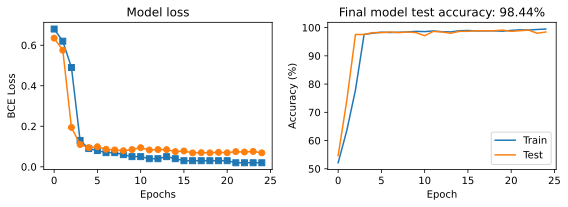

In [19]:
fig,ax = plt.subplots(1,2,figsize=(8,3))

ax[0].plot(Train_loss,'s-',label='Train')
ax[0].plot(Test_loss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('BCE Loss')
ax[0].set_title('Model loss')

ax[1].plot(TrainAcc,label='Train')
ax[1].plot(TestAcc, label='Test')

ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Epoch')
ax[1].set_title(f'Final model test accuracy: {TestAcc[-1]:.2f}%')
ax[1].legend()

fig.tight_layout()

plt.show()

## 8. Visualize some Images

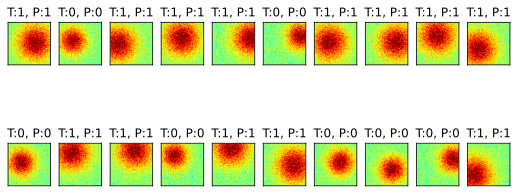

In [20]:
X,y = next(iter(test_loader)) # extract X,y from test dataloader
yHat = trained_Model(X)  # yHat : real number greater than or less than one

fig,axs = plt.subplots(2,10,figsize=(9,4), dpi=135)

for i,ax in enumerate(axs.flatten()):
    
    G = torch.squeeze( X[i,0,:,:] ).detach()
    ax.imshow(G,vmin=-1,vmax=1,cmap='jet')
    
    t = ( int(y[i].item()) , int(yHat[i].item()>0) )
    
    ax.set_title('T:%s, P:%s'%t)
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

## 9. Look at the filters

In [21]:
print(trained_Model)

layer1W = trained_Model.enc[0].weight
layer3W = trained_Model.enc[3].weight

print(' ')
print(layer1W.shape)
print(layer3W.shape)

gausnet(
  (enc): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1936, out_features=50, bias=True)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)
 
torch.Size([6, 1, 3, 3])
torch.Size([4, 6, 3, 3])


#### Visualizing Convolution Kernels

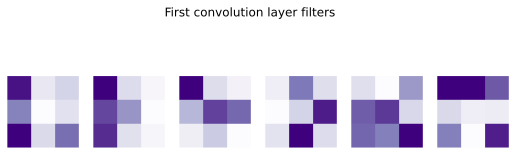

In [22]:
fig,axs = plt.subplots(1,6,figsize=(9,3), dpi=135)

for i,ax in enumerate(axs.flatten()):
    
    ax.imshow( torch.squeeze(layer1W[i,:,:,:]).detach() ,cmap='Purples')
    ax.axis('off')

plt.suptitle('First convolution layer filters')
plt.show()

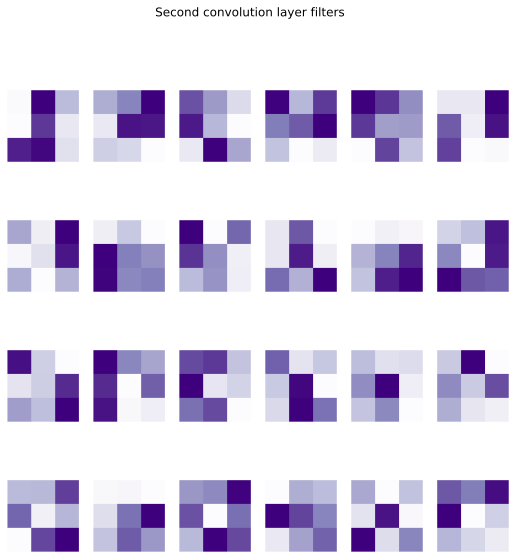

In [23]:
fig,axs = plt.subplots(4,6,figsize=(9,9), dpi=135)

for i in range(6*4):
    
    idx = np.unravel_index(i,(4,6))
    axs[idx].imshow( torch.squeeze(layer3W[idx[0],idx[1],:,:]).detach() ,cmap='Purples')
    axs[idx].axis('off')

plt.suptitle('Second convolution layer filters')
plt.show()